# PatternNet example on MNIST
This notebook trains a classification network on the MNIST data set and subsequently creates a PatternNet for this network and shows how to use PatternNet for signal computation.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import networks
from utils import load_data_mnist as load_data
from utils import accuracy, train


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Data and MNIST network 

In [2]:
# get the data
trainloader, testloader, _ = load_data(128)

# initialize the MNIST network
net = networks.MnistNet()

In [3]:
# set the number of epochs used for training
train_epochs = 2

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# train the network
train(net, train_epochs, trainloader, criterion, optimizer)

# get the accuracy
accuracy(net, testloader)

Finished Training in 53 seconds
Accuracy: 0.987600


0.9876

In [4]:
# get test images, always use the same for easier comparisons
data = np.load("test_images.npy")

# reshape for pytorch usage
data = torch.FloatTensor(data.transpose(0,3,1,2))

## Create Patternnet

In [5]:
# initialize patternnet with the MNIST networks' layers
patternnet = networks.PatternNet(net.layers)

In [6]:
# compute statistics 
patternnet.compute_statistics(data)
# compute patterns
patternnet.compute_patterns()
# set patterns
patternnet.set_patterns()

## Signal examples

In [7]:
# function to normalize images such that the maximum value is 1 and the minimum 0
def normalize_img(img):
    img_n = img - img.min()
    img_n = img_n / img_n.max()
    
    return img_n

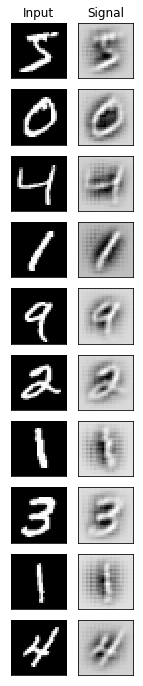

In [8]:
# compute signals
signals = patternnet(data[:10])

# plot signals
plt.figure(figsize=(7,12))
for i in range(10):
    plt.subplot(10,6,i*6+2)
    if i == 0:
        plt.title('Signal')
    plt.imshow(normalize_img(signals.data[i,0]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(10,6,i*6+1)
    if i == 0:
        plt.title('Input')
    plt.imshow(normalize_img(data[i,0]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.show()